n = 1
 Min Delta = 1.3823858993053837
Value Function:  [10.02266505  9.91030115 10.15528153 10.07735029 10.25345947  9.91542302
  9.85195824 10.1902582   9.78767487 10.27243427] 

n = 2
 Min Delta = 0.5890616066114359
Value Function:  [10.71518681 10.60521415 10.51013198 10.63819344 10.62803741 10.65813284
 10.74139416 10.64476897 10.41738862 10.79193222] 

n = 4
 Min Delta = 0.36334720567887796
Value Function:  [10.21474093 10.42999579 10.36455536 10.55943925 10.29861216 10.4445275
 10.66822982 10.34791852 10.27419127 10.34120307] 

n = 8
 Min Delta = 4.474840563278559
Value Function:  [9.02868463 9.12345431 9.18912072 9.03878574 8.92573358 9.00316229
 8.87434447 9.21910012 7.97150827 9.34653245] 

n = 16
 Min Delta = 1.758416258828871
Value Function:  [12.03609845 11.28582417 11.82300967 11.95704982 11.92199483 11.77208072
 11.65100167 12.09736567 12.66928217 12.04414743] 

n = 32
 Min Delta = 0.5994862962813186
Value Function:  [10.34145105 10.36664817 10.24052071 10.21604243 10.089

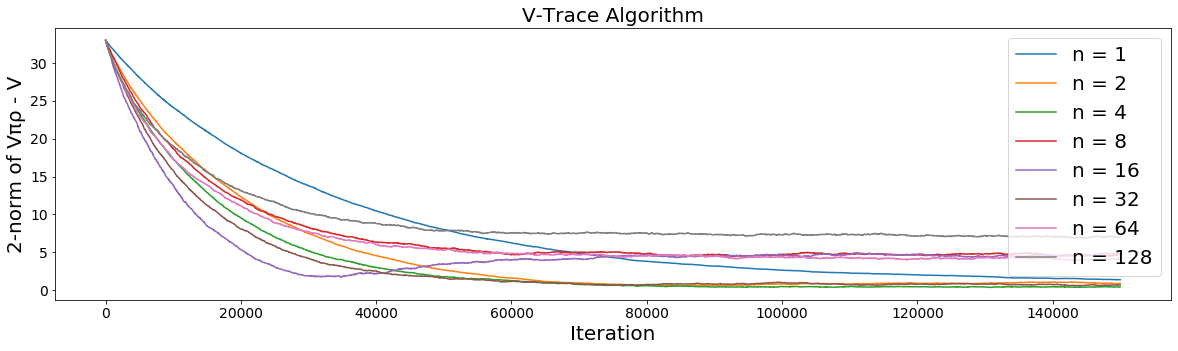

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import mdptoolbox.example


class VTraceTDLearner:
    """
    Class that will ues on policy temporal difference
    prediction to solve the model free problem with a given policy

    """

    def __init__(self, target_policy, behavior_policy, states, actions, alpha=0.01, gamma=0.95, beta = 0.5, diminish = None, T = 200, c_bar = 1, rho_bar = 1, iterations = 10000, epsilon = 0.01, n_step=3):
        #action value function, mapping each state action pair
        #initialized to have 0 for every new state action pair
        self.value_function = np.zeros(states)
        
        #discount rate between [0,1]
        self.gamma = gamma

        #step size between [0,1]
        self.alpha = alpha

        #the mapping of states to actions
        self.target_policy = target_policy
        self.behavior_policy = behavior_policy

        #the amount of states and actions
        self.states = states
        self.actions = actions
        #state space S
        self.state_space = np.arange(0,self.states)
        #action space A
        self.action_space = np.arange(0,self.actions)

        #transition probability matrix P, with shape AxSxS'
        self.transitionProbabilities, self.rewardMatrix = mdptoolbox.example.rand(states,actions)
        
        #the reward matrix
        self.rewardMatrix = np.random.rand(actions,states,states)

        #transition probability matrix under policy pi
        self.probabilityMatrix = np.zeros((self.states,self.states))
        
        
        #using behavior policy to forming it into a matrix
        self.policyMatrix = []
        for a, p in self.behavior_policy.items():
            self.policyMatrix.append(p)

        
        #only for diminishing step size using alpha and beta
        self.diminish = diminish
        self.step_size = self.alpha
        self.beta = beta
        
        #amount of iterations to run the environment for
        self.iterations = iterations
        
        #keeps track of the amount of times the states have been visited
        self.exploringStates = defaultdict(int)
        
        #estimated v_pi, using value iteration
        self.v_pi = [10.52097262,10.48180422,10.9314057 ,10.71975961,10.75916237,10.66013344,10.79103673,10.63960651,10.46499304,10.48157663]
        
        #save the difference between v_pi and v
        self.difference= []
        
        #n step trajecrtory you would like to 
        self.T = T
        self.n = n_step
        
        #truncated weights
        self.c_bar = c_bar
        self.rho_bar = rho_bar
        
        #epsilon
        self.epsilon = epsilon
        self.step_size = epsilon
        

        
    def setVpi(self,v_pi):
        """
        Set the estimated v_pi to what you found
        Must be called before running the environment
        Default reward matrix is set to what was found in value iteration
        
        For this to work
        :param v_pi: estimated v_pi, needs to be in length of state space S
        :returns: void
        """
        self.v_pi = v_pi  
        
    
    def setRewardMatrix(self,matrix):
        """
        Change the reward matrix to whatever you want with this function
        Must be called before running the environment
        Default reward matrix is set to random values between [0,1]
        
        For this to work
        Matrix needs to be in shape AxSxS
        A is the Action space
        S is the State space
        
        :param matrix: the reward matrix of choice
        :return: void
        """
        self.rewardMatrix = matrix
        
    def createProbabilityMatrix(self):
        
        #to run TD, the transition probability matrix has to be under the policy 
        #taking the sum of the probabilities of taking that action a under state s and multiplying that by the transition probability value 
        
        for s in range(self.states):
            probabilities = np.zeros(self.states)
            for a in range(self.actions):
                    action_prob = self.behavior_policy[s][a]
                    probabilities += self.transitionProbabilities[a][s]*action_prob
            self.probabilityMatrix[s] = probabilities
            

    def getNextState(self, state, action):
        """
        Just return the next state based on the transition probability matrix and the action taken
        Using random choice that will use a distribution to give a state
        :param state: observation that was previously seen
        :param action: action that was take
        :return: next state that the agent will go to 
        """
            
        next_state = np.random.choice(self.state_space,1,p = self.probabilityMatrix[state])
        return next_state[0]


    def getValue(self,state):
        """
        Just return the value of the state action pair given the current estimate of the environment
        :param state: observation that was previously seen
        :param action: action that was take
        :return: the value of that state action pair
        """

        return self.value_function[state]

    
    def chooseAction(self, state):
        """
        Using the current state and the given policy find the action  using random choice based on the probabilities
        """
        
        p = []
        for action,prob in sorted(self.behavior_policy[state].items()):
            p.append(prob)
            
        action = np.random.choice(self.action_space, 1, p = p)
        
        return action[0] 
    
    def takeAction(self, state, action):
        """
        perform the action given to find the next position in the MDP
        returns the next state and the reward from that transition
        """
        next_state = self.getNextState(state,action)
        reward = self.rewardMatrix[action][state][next_state]
        
        return next_state, reward
    
    
    def runEnvironment(self):
        """
        Will run the OpenGym AI environment set using on policy Temporal Difference Learning

        :param episodes: the number of episodes you would like to make the enviornment play
        :param maxtimesteps:
        :return: void

        """
        
        """
        Rough Estimate of the Value Function Limit
        [10.32698916 10.28997413 10.61215495 10.47182536 10.53804012 10.44741659
         10.58984017 10.28781177 10.42280426 10.27326007]
        """
        
        
    
        
        #create the transition probability matrix given the policy pi
        self.createProbabilityMatrix()
        
        for i in range(self.iterations):
            S = []
            R = [0]
            A = []

            #starting initial state
            state = np.random.randint(0,self.states)
            S.append(state)
            s = 0
            while True:

                if s<self.T:
                    action = self.chooseAction(S[s])
                    A.append(action)
                    next_state,reward = self.takeAction(S[s],action)
                    S.append(next_state)
                    self.exploringStates[next_state]+=1
                    R.append(reward)


                #tau is the timestep that the value function is being updated
                tau = s-self.n+1
                if tau>=0:

                    #update the value function
                        beta_summation = 0
                        for t in range(tau,min(tau+self.n,self.T)):
                            #calculate c_t
                            c_j = 1
                            for j in range(tau,t):
                                c_j *= min(self.c_bar, self.target_policy[S[j]][A[j]]/self.behavior_policy[S[j]][A[j]])
                                
                            #calculate rho_t    
                            rho_t = min(self.rho_bar, self.target_policy[S[t]][A[t]]/self.behavior_policy[S[t]][A[t]])
                            beta_summation  += (self.beta**(t-tau)) * c_j*  rho_t *(R[t] + self.beta*self.value_function[S[t+1]] - self.value_function[S[t]])
                        #finally update the value function 
                        self.value_function[S[tau]] += self.step_size* beta_summation

                        #calculate the difference
                        self.difference.append(np.linalg.norm(self.v_pi - self.value_function))
                    
                    
                if tau==self.T-1:
                    break

                s+=1
        
            
        return self.difference
        
    def plot(self):
        
        """
        Will plot the 2-norm difference found and more information on the results
        For debugging purposes
        """
        
        #info on the MDP
        print(f"MDP with {self.states} states and {self.actions} actions\ndiscounting factor gamma = {self.gamma}, step size alpha = {self.step_size}\n")
        print("Running ", self.iterations, "iterations")
        
        #info on the policy
        print("\nThe Policy is (state,action) = target probability    behavior probability")
        for s in range(self.states):
            for a in range(self.actions):
                print(f"({s},{a}) = {self.target_policy[s][a]}      {self.behavior_policy[s][a]} ",end=" ")
            print()
                      
        
        #plot the difference between v-pi and v
        plt.figure(figsize=(15,5))
        plt.plot(range(len(self.difference)), self.difference, 'b-')
        plt.title("V-trace TD with Importance Sampling",fontsize = 20)
        plt.xlabel("TimeStep",fontsize = 20)
        plt.ylabel("2-norm of Vπ - V",fontsize = 20)
        plt.xticks(fontsize = 14)
        plt.yticks(fontsize = 14)
        plt.show()
        
        #info on the value function
        print("Value Function:  ", self.value_function)
        print("\nMinimum Delta:  ", min(self.difference))
        print("explored states: ", self.exploringStates)

    def getValueFunction(self):
        return self.value_function
  


if __name__ == '__main__':
    """
    The Main Function to Run your program
    Example code given below
    All hyperparameters can be adjusted to your liking
    
    
    Policy must be given  
    the policy will be in the format of 
    (state,action) = Probability
    
    in python code it will be a dictionary inside of a dictionary
    {state: {action: probability of that action, action: probabiity, ... } state:{...}}
    """
    np.random.seed(0)
    
    target_policy = {0: {0: 0.4835164835164835, 1: 0.5164835164835165}, 1: {0: 0.48854961832061067, 1: 0.5114503816793893}, 2: {0: 0.881578947368421, 1: 0.11842105263157894}, 3: {0: 0.7980769230769231, 1: 0.20192307692307693}, 4: {0: 0.2926829268292683, 1: 0.7073170731707317}, 5: {0: 0.4430379746835443, 1: 0.5569620253164557}, 6: {0: 0.88, 1: 0.12}, 7: {0: 0.4715447154471545, 1: 0.5284552845528455}, 8: {0: 0.30952380952380953, 1: 0.6904761904761905}, 9: {0: 0.34328358208955223, 1: 0.6567164179104478}}
    behavior_policy = {0: {0: 0.4351851851851852, 1: 0.5648148148148148}, 1: {0: 0.423728813559322, 1: 0.576271186440678}, 2: {0: 0.5714285714285714, 1: 0.42857142857142855}, 3: {0: 0.1, 1: 0.9}, 4: {0: 0.49382716049382713, 1: 0.5061728395061729}, 5: {0: 0.2824427480916031, 1: 0.7175572519083969}, 6: {0: 0.42168674698795183, 1: 0.5783132530120482}, 7: {0: 0.1, 1: 0.9}, 8: {0: 0.8636363636363636, 1: 0.13636363636363635}, 9: {0: 0.3401360544217687, 1: 0.6598639455782312}}
    
    states = 10
    actions = 2
    c_bar = 1
    rho_bar = 1
    iterations = 750
    
        
    
    

    #multiple T values on the same plot
    plt.figure(figsize = (20,5))
    for n in range(0,8):
        learner = VTraceTDLearner(beta = 0.95, n_step = 2**n,target_policy = target_policy, behavior_policy = behavior_policy,states = states, actions = actions, epsilon = 0.01, iterations = iterations, c_bar = c_bar, rho_bar = rho_bar)
        plot = learner.runEnvironment()
        print(f"n = {2**n}\n Min Delta = {min(plot)}")
        print("Value Function: ", learner.getValueFunction(),"\n")
        plt.plot(range(len(plot)), plot, label = f"n = {2**n}")
    plt.legend(fontsize = 20)
    plt.title("V-Trace Algorithm", fontsize = 20)
    plt.xlabel("Iteration",fontsize = 20)
    plt.ylabel("2-norm of Vπρ - V",fontsize = 20)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.show()
    
    
#     #only one T value run
#     print("With Constant Step Size\n")
#     learner = VTraceTDLearner(target_policy = target_policy, behavior_policy = behavior_policy,states = states, actions = actions, epsilon = 0.01, iterations = iterations, c_bar = c_bar, rho_bar = rho_bar)
#     learner.runEnvironment()
#     learner.plot()
    


